In [43]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Complete train/test/submit notebook - https://drive.google.com/file/d/1xkS8eSxzq6fusPTCv3y-EKhYiCeTdCLM/view?usp=sharing


In [2]:
!pip install tensorflow-gpu==1.15

     |████████████████████████████████| 411.5 MB 6.4 kB/s  eta 0:00:01    |███████                         | 89.1 MB 50.1 MB/s eta 0:00:07     |█████████▍                      | 120.5 MB 50.1 MB/s eta 0:00:06     |█████████▋                      | 124.2 MB 50.1 MB/s eta 0:00:06     |██████████                      | 128.8 MB 50.1 MB/s eta 0:00:06MB/s eta 0:00:06     |██████████████████████████▋     | 342.7 MB 61.0 MB/s eta 0:00:02
     |████████████████████████████████| 501 kB 41.4 MB/s eta 0:00:01     |████████████████████████████████| 503 kB 41.4 MB/s 
     |████████████████████████████████| 3.8 MB 36.2 MB/s eta 0:00:01
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7539 sha256=a5476b502211b0d91eaa661cc8cf2b187a1cd21ae5cfcfa68f50e07967a8dace
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incom

In [3]:
import tensorflow as tf
print(tf.__version__)#1.15.0
import keras
print(keras.__version__)#2.3.1

1.15.0
2.3.1


Using TensorFlow backend.


In [4]:
keras.backend.tensorflow_backend._get_available_gpus()

[]

In [5]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [6]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import cv2
import time
from collections import Counter
!python --version
!git clone https://github.com/matterport/Mask_RCNN.git
!cd Mask_RCNN ; python setup.py install
!pip show mask-rcnn
from os import sys
sys.path.append('./Mask_RCNN/')
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

Python 3.7.6
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.76 MiB | 31.87 MiB/s, done.
Resolving deltas: 100% (566/566), done.
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/uti

In [9]:
train_csv=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/train.csv"))
df=train_csv.copy(deep=True)
df.head(),df.shape

(       name   x1   x2   y1   y2       classname
 0  2756.png   69  126  294  392  face_with_mask
 1  2756.png  505   10  723  283  face_with_mask
 2  2756.png   75  252  264  390   mask_colorful
 3  2756.png  521  136  711  277   mask_colorful
 4  6098.jpg  360   85  728  653    face_no_mask,
 (15412, 6))

In [10]:
submission=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/submission.csv"))
submission.head()

,name,x1,x2,y1,y2,classname
0,1800.jpg,NaN,NaN,NaN,NaN,NaN
1,1800.jpg,NaN,NaN,NaN,NaN,NaN
2,1800.jpg,NaN,NaN,NaN,NaN,NaN
3,1799.jpg,NaN,NaN,NaN,NaN,NaN
4,1799.jpg,NaN,NaN,NaN,NaN,NaN


In [11]:
bbox=[]
for i in range(len(train_csv)):
    arr=[]
    for j in df.iloc[i][['x1','x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
df["bbox"]=bbox
df.head()

,name,x1,x2,y1,y2,classname,bbox
0,2756.png,69,126,294,392,face_with_mask,"[69, 126, 294, 392]"
1,2756.png,505,10,723,283,face_with_mask,"[505, 10, 723, 283]"
2,2756.png,75,252,264,390,mask_colorful,"[75, 252, 264, 390]"
3,2756.png,521,136,711,277,mask_colorful,"[521, 136, 711, 277]"
4,6098.jpg,360,85,728,653,face_no_mask,"[360, 85, 728, 653]"


In [12]:
train_csv.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [13]:
def get_boxes(id):
    boxes=[]
    c_names=[]
    dt=df[df['name']==str(id)]
    for i in range(len(dt)):
        boxes.append(dt.iloc[i]['bbox'])
        c_names.append(dt.iloc[i]['classname'])
    return boxes,c_names
# print(get_boxes('1812.jpg'))
boxes,c_names=get_boxes('1812.jpg')
print(boxes)
print(c_names)

[[636, 47, 711, 133], [465, 52, 581, 189], [468, 123, 537, 194], [636, 86, 691, 137], [636, 78, 679, 107], [241, 102, 292, 169], [240, 130, 271, 164], [91, 125, 148, 183], [157, 124, 190, 173], [910, 143, 936, 178]]
['face_with_mask', 'face_with_mask', 'mask_surgical', 'mask_surgical', 'eyeglasses', 'face_with_mask', 'mask_colorful', 'face_no_mask', 'face_no_mask', 'face_no_mask']


In [14]:
ctr=Counter(df['classname'])
print(len(ctr),ctr)
ct=list(ctr)
ct

20 Counter({'face_with_mask': 4180, 'mask_surgical': 2430, 'mask_colorful': 1876, 'face_no_mask': 1569, 'face_other_covering': 1372, 'eyeglasses': 914, 'hat': 823, 'sunglasses': 358, 'hair_net': 287, 'scarf_bandana': 260, 'goggles': 192, 'helmet': 187, 'hijab_niqab': 173, 'face_shield': 160, 'hood': 159, 'face_with_mask_incorrect': 150, 'balaclava_ski_mask': 134, 'turban': 94, 'gas_mask': 55, 'other': 39})


['face_with_mask',
 'mask_colorful',
 'face_no_mask',
 'face_with_mask_incorrect',
 'mask_surgical',
 'face_other_covering',
 'scarf_bandana',
 'eyeglasses',
 'helmet',
 'face_shield',
 'sunglasses',
 'hood',
 'hat',
 'goggles',
 'hair_net',
 'hijab_niqab',
 'other',
 'gas_mask',
 'balaclava_ski_mask',
 'turban']

In [15]:
SUB_DATA=list(set(submission['name']))
len(list(SUB_DATA)),SUB_DATA[:10]

(1698,
 ['0629.jpg',
  '1684.jpg',
  '1017.jpg',
  '0049.jpg',
  '0168.png',
  '0893.jpg',
  '1787.jpg',
  '1545.jpg',
  '0917.jpg',
  '1753.jpg'])

In [16]:
ct.insert(0,'BG')
ct

['BG',
 'face_with_mask',
 'mask_colorful',
 'face_no_mask',
 'face_with_mask_incorrect',
 'mask_surgical',
 'face_other_covering',
 'scarf_bandana',
 'eyeglasses',
 'helmet',
 'face_shield',
 'sunglasses',
 'hood',
 'hat',
 'goggles',
 'hair_net',
 'hijab_niqab',
 'other',
 'gas_mask',
 'balaclava_ski_mask',
 'turban']

In [18]:
class wobotDataset(Dataset):
    
    def load_dataset_2(self):
        for i in range(len(SUB_DATA)):
            di=SUB_DATA[i]
            self.add_image(
                'wobot',
                image_id=di,
                image_id_df=di,
                path=os.path.join(images,di)
            )

    def load_dataset(self,train_bool):
        D_DATA=[]
        if(train_bool):
            D_DATA=train_DATA
        else:
            D_DATA=test_DATA
            
        for i in range(len(ct)):
            self.add_class("wobot", i+1, ct[i])

        for i in range(len(D_DATA)):
            di=D_DATA[i]
            self.add_image(
                'wobot',
                image_id=di[0],
                image_id_df=di[0],
                path=os.path.join(images,di[0]),
                class_names=di[-1],
                height=di[1],
                width=di[2]
                          )
            
    def get_boxes(self,id):
        boxes=[]
        c_names=[]
        dt=df[df['name']==str(id)]
        for i in range(len(dt)):
            boxes.append(dt.iloc[i]['bbox'])
            c_names.append(dt.iloc[i]['classname'])
        return boxes,c_names
 
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        w=info['width']
        h=info['height']
        image_id_df=info['image_id_df']
        boxes,c_names= self.get_boxes(image_id_df)
        masks = np.zeros((h, w, len(boxes)), dtype='uint8')
        class_ids = list()
        for i in range(len(boxes)):
#             print('i->'+str(i))
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(c_names[i]))
        return masks, np.asarray(class_ids, dtype='int32')
 
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# class wobotConfig(Config):
#     NAME = 'wobot_cfg'
#     NUM_CLASSES = 1 + 20
#     IMAGES_PER_GPU = 1
#     STEPS_PER_EPOCH = len(train_set.image_ids)
 
# config = wobotConfig()

# from mrcnn import
class MaskRCNN(MaskRCNN):
    def __init__(self, mode, config, model_dir):
        """
        mode: Either "training" or "inference"
        config: A Sub-class of the Config class
        model_dir: Directory to save training logs and trained weights
        """
        assert mode in ['training', 'inference']
        self.mode = mode
        self.config = config
        self.model_dir = model_dir
        self.set_log_dir()
        self.keras_model = self.build(mode=mode, config=config)
        
        self.keras_model.metrics_tensors = []
    
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

class PredictionConfig(Config):
    NAME = 'wobot_cfg'
    NUM_CLASSES = 1 + 20
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


In [19]:
#https://drive.google.com/file/d/1XtgbixT2EKzteuiT2uLuzdWFgJt_Nz6g/view?usp=sharing
!wget "https://drive.google.com/uc?export=download&id=1XtgbixT2EKzteuiT2uLuzdWFgJt_Nz6g"

--2020-06-16 06:49:06--  https://drive.google.com/uc?export=download&id=1XtgbixT2EKzteuiT2uLuzdWFgJt_Nz6g
Resolving drive.google.com (drive.google.com)... 209.85.146.100, 209.85.146.138, 209.85.146.101, ...
Connecting to drive.google.com (drive.google.com)|209.85.146.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘uc?export=download&id=1XtgbixT2EKzteuiT2uLuzdWFgJt_Nz6g’

uc?export=download&     [ <=>                ]   3.19K  --.-KB/s    in 0s      

2020-06-16 06:49:06 (33.1 MB/s) - ‘uc?export=download&id=1XtgbixT2EKzteuiT2uLuzdWFgJt_Nz6g’ saved [3265]



In [24]:
!wget 'https://drive.google.com/file/d/1XtgbixT2EKzteuiT2uLuzdWFgJt_Nz6g/view?usp=sharing'

--2020-06-16 06:56:57--  https://drive.google.com/file/d/1XtgbixT2EKzteuiT2uLuzdWFgJt_Nz6g/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 209.85.146.100, 209.85.146.113, 209.85.146.138, ...
Connecting to drive.google.com (drive.google.com)|209.85.146.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=sharing’

view?usp=sharing        [ <=>                ]  68.21K  --.-KB/s    in 0.004s  

2020-06-16 06:56:57 (18.2 MB/s) - ‘view?usp=sharing’ saved [69845]



In [25]:
!ls

 Mask_RCNN
 __notebook_source__.ipynb
 mask_rcnn_wobot_cfg_0002.h5
'uc?export=download&id=1XtgbixT2EKzteuiT2uLuzdWFgJt_Nz6g'
'view?usp=sharing'


In [21]:
!curl -L -o mask_rcnn_wobot_cfg_0002.h5 "https://drive.google.com/uc?export=download&id=1XtgbixT2EKzteuiT2uLuzdWFgJt_Nz6g"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3265    0  3265    0     0  18657      0 --:--:-- --:--:-- --:--:-- 18657


In [22]:
!ls

 Mask_RCNN
 __notebook_source__.ipynb
 mask_rcnn_wobot_cfg_0002.h5
'uc?export=download&id=1XtgbixT2EKzteuiT2uLuzdWFgJt_Nz6g'


In [30]:
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model.load_weights('../input/maskrcnn-model/mask_rcnn_wobot_cfg_0002.h5', by_name=True)

In [32]:
images=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images")
print(len(os.listdir(images)))

6024


In [33]:
submission_set = wobotDataset()
submission_set.load_dataset_2()
submission_set.prepare()
print('submission: %d' % len(submission_set.image_ids))

submission: 1698


In [41]:
# count_sub=0
# for image_id in submission_set.image_ids:
#     count_sub+=1
#     info = submission_set.image_info[image_id]
#     print(info)

In [42]:
# print(count_sub)

In [36]:
sub_df=pd.DataFrame(columns=['name','x1','x2','y1','y2','classname'])
printer=0
for image_id in submission_set.image_ids:
#     ####
#     if image_id>5:
#         break
#     ####
    
    image = submission_set.load_image(image_id)
    name = submission_set.image_info[image_id]['image_id_df']
    
    scaled_image = mold_image(image, cfg)
    sample = np.expand_dims(scaled_image, 0)
    yhat = model.detect(sample, verbose=0)
#     x2,x1,y2,y1
    r=yhat[0]
    subb=r['rois']
    subc=r['class_ids']
    subc2=[ct[x] for x in subc]
    subb,subc,subc2
    
    for (i,j) in zip(subb,subc2):
        x2,x1,y2,y1=i
        classname=j
        sub_df.loc[len(sub_df)]=(name,x1,x2,y1,y2,classname)
        
    if(printer%100==0):
        print(printer)
    printer+=1
    
print(sub_df.shape)

0
100


KeyboardInterrupt: 

In [38]:
# printer

In [49]:
sub_df

,name,x1,x2,y1,y2,classname
0,0629.jpg,501,315,643,443,mask_surgical
1,0629.jpg,443,169,713,315,hat
2,0629.jpg,472,163,712,436,face_with_mask
3,0629.jpg,478,281,689,477,scarf_bandana
4,0629.jpg,477,180,724,487,face_other_covering
...,...,...,...,...,...,...
826,1578.jpg,189,230,226,257,mask_colorful
827,1366.jpg,386,103,533,284,face_with_mask
828,1366.jpg,413,201,520,284,mask_surgical
829,1366.jpg,383,99,537,216,hair_net


In [50]:
from mrcnn import visualize

Processing 1 images
image                    shape: (1024, 769, 3)        min: -123.70000  max:  151.10000  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -247.40000  max:   47.20001  float64
image_metas              shape: (1, 33)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


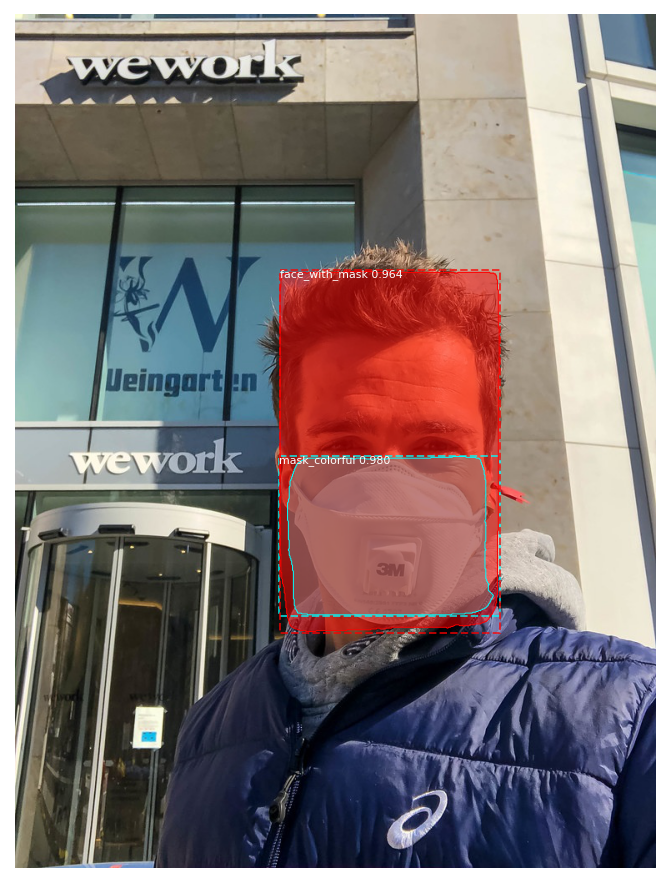

In [51]:
image = submission_set.load_image(1673)
scaled_image = mold_image(image, cfg)
sample = np.expand_dims(scaled_image, 0)
yhat = model.detect(sample, verbose=1)
r = yhat[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], ct, r['scores'])


Processing 1 images
image                    shape: (682, 1024, 3)        min: -123.70000  max:  151.10000  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -247.40000  max:   47.20001  float64
image_metas              shape: (1, 33)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


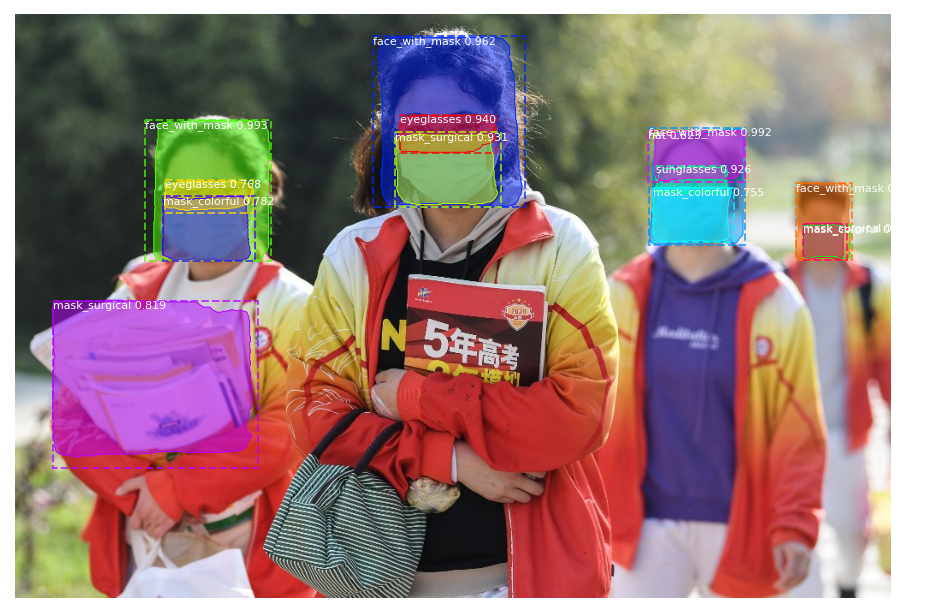

In [52]:
image = submission_set.load_image(1674)
scaled_image = mold_image(image, cfg)
sample = np.expand_dims(scaled_image, 0)
yhat = model.detect(sample, verbose=1)

from mrcnn import visualize

r = yhat[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ct, r['scores'])

In [ ]:
submit_csv=sub_df.sort_values('name',ascending=False)#,inplace=True
print(submit_csv.shape)
submit_csv

In [ ]:
submit_csv.to_csv('submission.csv',index=False)
submit_csv=pd.read_csv('submission.csv')
submit_csv